# Digital House - Data Science a Distancia

## Trabajo Práctico 2



### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Mayo 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import statsmodels.api as sm

In [5]:
# Ignore some warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

---
#### Dataset

In [6]:
data_final_url = "../Data/properatti_final6.csv"
data = pd.read_csv(data_final_url, encoding="utf-8")


---
#### Seleccionar, renombrar y ajustar valores de las características

In [7]:
if 'Unnamed: 0' in list(data.columns) :
    data = data.drop(columns=['Unnamed: 0']).copy()

In [8]:
data.rename(columns={'property_type' : 'tipo'}, inplace=True)
data.rename(columns={'price_aprox_usd' : 'precio'}, inplace=True)
data.rename(columns={'surface_covered_in_m2' : 'superficie'}, inplace=True)

In [9]:
# Trabajar con precio en miles de dólares
#data['precio'] = (data['precio'] / 1000).round(3)

In [10]:
# Ajustar la cantidad de ambientes de [1, 7 o más]
data['ambientes'] = data['ambientes'].apply(lambda x : x if x < 7 else 7) 

In [11]:
# Ajustar la cantidad de baños de [1, 3 o más]
data['baños'] = data['baños'].apply(lambda x : x if x < 3 else 3)

---
#### Dummies

In [12]:
dummies = pd.get_dummies(data=data['tipo'], drop_first=True)
dummies.index = data.index
data = pd.concat([data, dummies], axis=1)

In [13]:
#dummies = pd.get_dummies(data=data['state_name'], prefix='sn', drop_first=True)
#data = pd.concat([data, dummies], axis=1)
#state_name_features = list(dummies.columns)
state_name_features = []

In [14]:
dummies = pd.get_dummies(data=data['place_name'], prefix='pn', drop_first=True)
data = pd.concat([data, dummies], axis=1)
place_name_features = list(dummies.columns)

---

In [15]:
data.shape

(47037, 117)

In [16]:
data.head()

,tipo,place_name,state_name,precio,superficie,ambientes,baños,balcón,cochera,parrilla,...,pn_Villa Bosch,pn_Villa Crespo,pn_Villa Devoto,pn_Villa Lugano,pn_Villa Luro,pn_Villa Luzuriaga,pn_Villa Pueyrredón,pn_Villa Sarmiento,pn_Villa Urquiza,pn_Villa del Parque
0,apartment,Mataderos,Capital Federal,72000.0,55.0,2.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PH,Munro,Bs.As. G.B.A. Zona Norte,130000.0,78.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,apartment,Belgrano,Capital Federal,138000.0,40.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,apartment,Belgrano,Capital Federal,195000.0,60.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,apartment,Palermo Soho,Capital Federal,111700.0,30.0,1.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


---


In [17]:

sns.set()
plt.style.use('seaborn')

sns.mpl.rcParams['axes.titlesize'] = 20
sns.mpl.rcParams['axes.labelsize'] = 16


In [18]:
features = ['apartment', 'house', 'superficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']
target = 'precio'

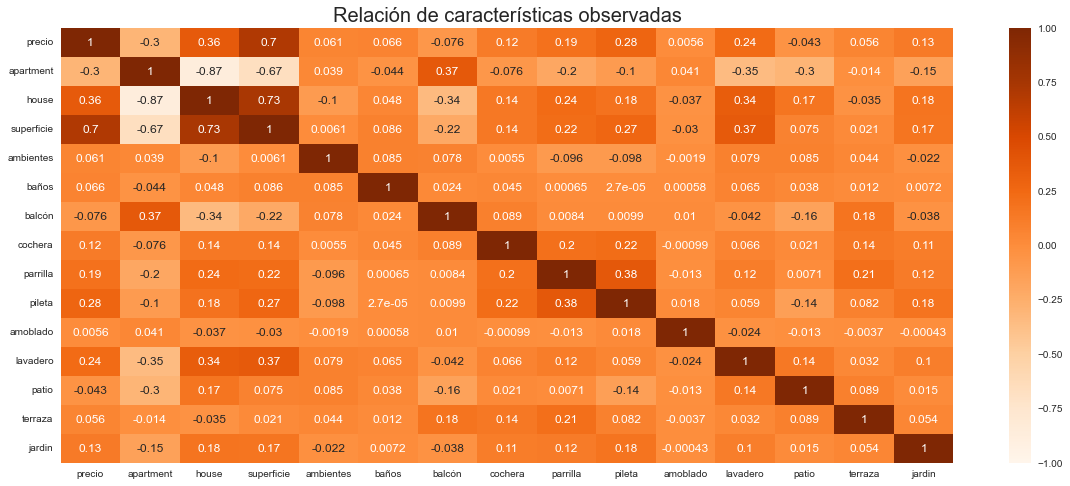

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data[[target] + features].corr(), annot=True, vmin=-1, vmax=1, cmap='Oranges', ax=ax)
ax.set(title='Relación de características observadas')
plt.show()

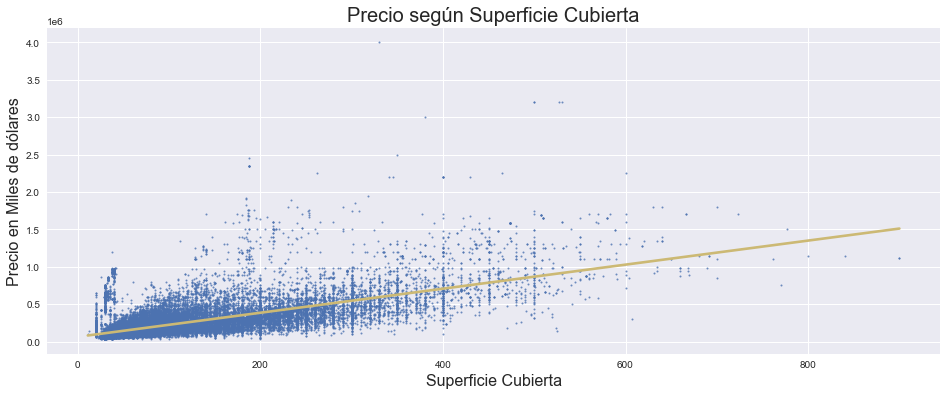

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.regplot(data=data, x='superficie', y='precio', ci=None, color='y', scatter_kws={'color':'b', 's':4}, ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.show()

---
#### Variables calculadas

In [21]:
data['logsuperficie'] = np.log(data['superficie'])

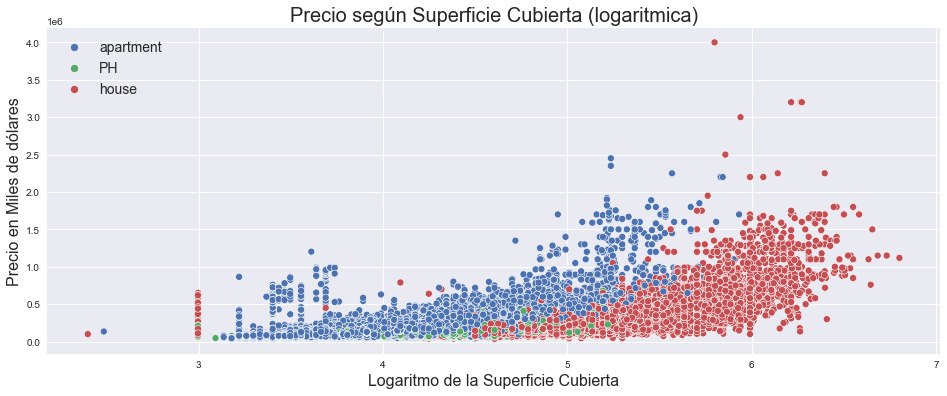

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.scatterplot(data=data, x='logsuperficie', y='precio', ci=None, hue='tipo', ax=ax)
ax.set(title='Precio según Superficie Cubierta (logaritmica)', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Logaritmo de la Superficie Cubierta')
plt.legend(loc='upper left', fontsize=14)
plt.show()

---



In [23]:
def r2_adjust(r2, n, p) :
    u''' Calculate R^2 adjusted for n observations and p grades of freedom '''
    return (1 - (1 - r2) * ((n - 1) / (n - p - 1) ))

In [24]:
def train_LinearRegression(X, y) :
    u""" Performs Ordinary Least Squares linear regression from Scikit-Learn linear models

    Args:
        * X array of array of features values
        * y array of target values
    Returns:
        a model fit objetct and a dataframe with metrics; MAE sqrt MSE, ^2 adj

    """
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    ymodel = model.predict(Xtrain)
    ypred = model.predict(Xtest)
    
    df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame(columns=['Features'], data=[ str(list(X.columns)) ])], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['MAE'], data=[ mean_absolute_error(ytest, ypred).round(3) ])], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['sqrt MSE'], data=[ np.sqrt(mean_squared_error(ytest, ypred)).round(3) ])], axis=1)

    #r2_train = (1 - (1 - r2_score(ytrain, ymodel)) * ((len(ytrain) - 1) / (len(ytrain) - len(X.columns) - 1) )).round(3)
    r2_train = r2_adjust(r2_score(ytrain, ymodel), len(ytrain), len(X.columns))
    
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj train'], data=[ r2_train ])], axis=1)

    #r2_test = (1 - (1 - r2_score(ytest, ypred)) * ((len(ytest) - 1) / (len(ytest) - len(X.columns) - 1) )).round(3)
    r2_test = r2_adjust(r2_score(ytest, ypred), len(ytest), len(X.columns))
    df = pd.concat([df, pd.DataFrame(columns=['R^2 adj test'], data=[ r2_test ])], axis=1)
    
    return model, df, Xtest, ytest


---
### Train models


In [25]:

y = data['precio']
metrics = pd.DataFrame()

data['s2'] = data['logsuperficie'] ** 2
data['s3'] = data['logsuperficie'] ** 3
data['s4'] = data['logsuperficie'] ** 4
data['s5'] = data['logsuperficie'] ** 5


In [26]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [27]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin'] \
            + state_name_features + place_name_features

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [28]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin'] \
            + state_name_features + place_name_features

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [29]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin'] \
            + state_name_features + place_name_features

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [30]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3', 's4',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin'] \
            + state_name_features + place_name_features

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [31]:

features = ['apartment', 'house', 'superficie', 'logsuperficie',
            's2', 's3', 's4', 's5',
            'ambientes', 'baños',
            'balcón', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin'] \
            + state_name_features + place_name_features

X = data[features]
model, metric, Xtest, ytest = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [32]:
pd.options.display.max_colwidth = 120

In [33]:
display(metrics.head(20))

,Features,MAE,sqrt MSE,R^2 adj train,R^2 adj test
0,"['apartment', 'house', 'superficie', 'logsuperficie', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta...",78194.934,142315.769,0.561386,0.541210
0,"['apartment', 'house', 'superficie', 'logsuperficie', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', 'pileta...",61971.097,111133.968,0.721785,0.717851
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 'ambientes', 'baños', 'balcón', 'cochera', 'parrilla', '...",62023.825,111126.855,0.721826,0.717863
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 'ambientes', 'baños', 'balcón', 'cochera', 'parril...",61578.355,110496.742,0.724965,0.721029
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 's4', 'ambientes', 'baños', 'balcón', 'cochera', '...",61327.630,110242.558,0.726464,0.722288
0,"['apartment', 'house', 'superficie', 'logsuperficie', 's2', 's3', 's4', 's5', 'ambientes', 'baños', 'balcón', 'coche...",61424.144,110051.581,0.726921,0.723225


In [34]:

ols = sm.OLS(y, sm.add_constant(X)).fit()

display(ols.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1063.
Date:                Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                        20:26:31   Log-Likelihood:            -6.1155e+05
No. Observations:               47037   AIC:                         1.223e+06
Df Residuals:                   46918   BIC:                         1.224e+06
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -2.507e+07   5.21e+06     -4.810      0.000   -3.53e+07   -1.49e+07
apartment                    3.872e+04   2475.810     15.641      0.000    3.39e+04    4.36e+04
house                       -2.732e+04   2809.943     -9.724      0.000   -3.28e+04   -2.18e+04
superficie                  -6.541e+04   5647.405    -11.583      0.000   -7.65e+04   -5.43e+04
logsuperficie                3.992e+07   6.52e+06      6.122      0.000    2.71e+07    5.27e+07
s2                          -2.374e+07   3.26e+06     -7.276      0.000   -3.01e+07   -1.73e+07
s3                           6.873e+06   8.26e+05      8.320      0.000    5.25e+06    8.49e+06
s4                          -9.761e+05   1.06e+05     -9.218      0.000   -1.18e+06   -7.69e+05
s5                           5.761e+04   5735.356     10.045      0.000    4.64e+04    6.89e+04
ambientes                     356.4202    484.158      0.736      0.462    -592.536    1305.376
baños                       -6660.8420   2583.841     -2.578      0.010   -1.17e+04   -1596.476
balcón                      -1897.5333   1147.067     -1.654      0.098   -4145.801     350.734
cochera                      6032.3242   1095.477      5.507      0.000    3885.173    8179.475
parrilla                     1.264e+04   1211.462     10.430      0.000    1.03e+04     1.5e+04
pileta                        1.11e+04   1266.042      8.767      0.000    8617.750    1.36e+04
amoblado                    -1.056e+04   6932.583     -1.523      0.128   -2.41e+04    3028.514
lavadero                     4840.3909   1166.812      4.148      0.000    2553.423    7127.359
patio                       -1.549e+04   1560.747     -9.924      0.000   -1.85e+04   -1.24e+04
terraza                      7158.6251   1194.667      5.992      0.000    4817.060    9500.190
jardin                       2078.9585   1854.976      1.121      0.262   -1556.822    5714.739
pn_Adrogué                   -7.21e+04   9544.191     -7.554      0.000   -9.08e+04   -5.34e+04
pn_Almagro                   -4.63e+04   9037.602     -5.123      0.000    -6.4e+04   -2.86e+04
pn_Avellaneda               -9.088e+04   1.04e+04     -8.759      0.000   -1.11e+05   -7.05e+04
pn_Balvanera                -7.246e+04   9552.022     -7.586      0.000   -9.12e+04   -5.37e+04
pn_Banfield                 -8.248e+04   9108.368     -9.056      0.000      -1e+05   -6.46e+04
pn_Barracas                 -7.123e+04   1.02e+04     -6.980      0.000   -9.12e+04   -5.12e+04
pn_Barrio Los Alisos         2.519e+04   1.06e+04      2.367      0.018    4334.937    4.61e+04
pn_Barrio Norte              2.486e+04   9045.258      2.749      0.006    7134.793    4.26e+04
pn_Beccar                   -6.115e+04   1.03e+04     -5.946      0.000   -8.13e+04    -4.1e+04
pn_Belgrano

In [35]:
# departamento de 1 m2 cubierto sin cochera ni pileta
#import math
#my_X = [[70, 70*70, 0, 0]]
#my_y = model.predict(my_X)[0]
#display(my_y, math.exp(my_y))

---
### Gauss-Markov


In [36]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - bserverd features
    * ytest - observed values
    """

    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x=ypred, y=ytest, lowess=True, line_kws={'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top=1.5, wspace=2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return


In [37]:
# CUIDADO !!! con un dataset grande demora mucho tiempo
#gauss_markov_test(Xtest, ytest)

---